In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

RANDOM_STATE = 42

피클 내용 확인하기

In [2]:
import pandas as pd

df = pd.read_pickle("diabetes.pkl")

print("피클 로드:", df.shape)
print(df.head())

피클 로드: (768, 8)
   n_Pregnancies  Glucose_Concentration  Blood_Pressure(mmHg)  \
0              6                    148                    72   
1              1                     85                    66   
2              8                    183                    64   
3              1                     89                    66   
4              0                    137                    40   

   Skin_Thickness(mm)   BMI  Diabetes_Pedigree_Function  Age  Outcome  
0                  35  33.6                       0.627   50        1  
1                  29  26.6                       0.351   31        0  
2                   0  23.3                       0.672   32        1  
3                  23  28.1                       0.167   21        0  
4                  35  43.1                       2.288   33        1  


방법1) 결측값 제거한 KNN

In [3]:
# 피클 로드
df = pd.read_pickle("diabetes_dropna.pkl")


# 3) feature / target 분리 (Outcome 칼럼 존재 가정)
if 'Outcome' not in df.columns:
    raise ValueError("데이터프레임에 'Outcome' 칼럼이 없습니다.")
X = df.drop(columns='Outcome')
y = df['Outcome']

# 4) train/test 분리 (stratify로 클래스 비율 유지)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print(f"\nTrain samples: {len(X_train)}, Test samples: {len(X_test)}")

# 5) Pipeline: 스케일러 -> KNN (이미 결측이 제거됐으므로 Imputer 없음)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# 6) 하이퍼파라미터 그리드 (필요하면 범위 확장)
param_grid = {
    'knn__n_neighbors': [3,5,7,9,11],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

# 7) GridSearchCV로 best 파라미터 탐색 (scoring: ROC-AUC)
gs = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

print("\nBest params:", gs.best_params_)
print("Best CV ROC-AUC: {:.3f}".format(gs.best_score_))

# 8) test 평가
best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

print(f"\nTest Accuracy: {acc:.3f}")
print(f"Test ROC-AUC:  {roc_auc:.3f}")
print("Confusion Matrix:\n", cm)


Train samples: 425, Test samples: 107

Best params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 11, 'knn__weights': 'distance'}
Best CV ROC-AUC: 0.807

Test Accuracy: 0.766
Test ROC-AUC:  0.834
Confusion Matrix:
 [[62  9]
 [16 20]]


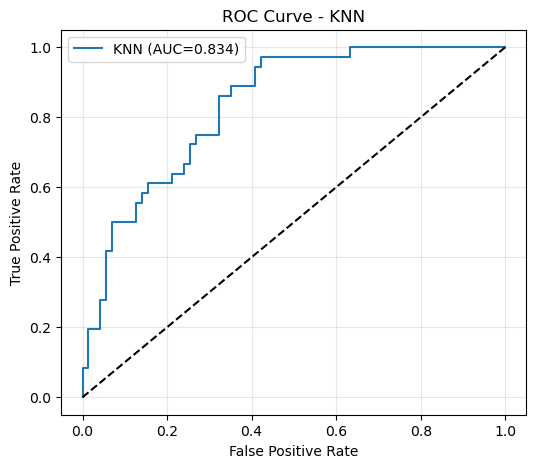

In [4]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'KNN (AUC={roc_auc:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


방법2) 결측치 중앙값 처리 KNN

In [5]:
# 1. 중앙값 처리 완료본 피클 로드
df = pd.read_pickle("diabetes_median.pkl")
print("피클 로드:", df.shape)

# 2. 결측치 여부 확인
print("결측치 개수:\n", df.isna().sum())

# 3. 입력 변수(X), 타겟(y) 분리
X = df.drop(columns='Outcome')
y = df['Outcome']

# 4. 학습/테스트 데이터 분리 (클래스 비율 유지)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", len(X_train), "Test:", len(X_test))

# 5. 표준화 + KNN 파이프라인 생성
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# 6. 최적 하이퍼파라미터 탐색
param_grid = {
    'knn__n_neighbors': [3,5,7,9,11],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}
gs = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

print("최적 파라미터:", gs.best_params_)
print("교차검증 ROC-AUC:", gs.best_score_)

# 7. 테스트 평가
best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

print(f"테스트 Accuracy: {acc:.3f}")
print(f"테스트 ROC-AUC: {roc_auc:.3f}")
print("혼동 행렬:\n", cm)

피클 로드: (768, 8)
결측치 개수:
 n_Pregnancies                 0
Glucose_Concentration         0
Blood_Pressure(mmHg)          0
Skin_Thickness(mm)            0
BMI                           0
Diabetes_Pedigree_Function    0
Age                           0
Outcome                       0
dtype: int64
Train: 614 Test: 154
최적 파라미터: {'knn__metric': 'euclidean', 'knn__n_neighbors': 11, 'knn__weights': 'uniform'}
교차검증 ROC-AUC: 0.8229464285714286
테스트 Accuracy: 0.734
테스트 ROC-AUC: 0.796
혼동 행렬:
 [[85 15]
 [26 28]]


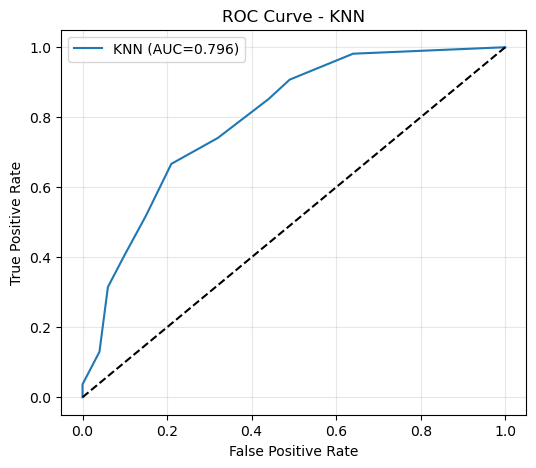

In [ ]:
# 8. ROC 곡선 시각화
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'KNN (AUC={roc_auc:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

방법3) 평균으로 대체한 KNN

In [7]:
# 1. 평균값 처리 피클 로드
df = pd.read_pickle("diabetes_mean.pkl")
print("피클 로드:", df.shape)

# 2. 결측치 확인
print("결측치 개수:\n", df.isna().sum())

# 3. 입력 변수(X) / 타깃(y) 분리
X = df.drop(columns='Outcome')
y = df['Outcome']

# 4. 학습/테스트 데이터 분리 (클래스 비율 유지)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", len(X_train), "Test:", len(X_test))

# 5. 파이프라인: 표준화 + KNN
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# 6. 하이퍼파라미터 탐색 (GridSearchCV)
param_grid = {
    'knn__n_neighbors': [3,5,7,9,11],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}
gs = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
gs.fit(X_train, y_train)
print("최적 파라미터:", gs.best_params_)
print("교차검증 ROC-AUC:", gs.best_score_)

# 7. 테스트 평가
best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

print(f"테스트 Accuracy: {acc:.3f}")
print(f"테스트 ROC-AUC: {roc_auc:.3f}")
print("혼동 행렬:\n", cm)

피클 로드: (768, 8)
결측치 개수:
 n_Pregnancies                 0
Glucose_Concentration         0
Blood_Pressure(mmHg)          0
Skin_Thickness(mm)            0
BMI                           0
Diabetes_Pedigree_Function    0
Age                           0
Outcome                       0
dtype: int64
Train: 614 Test: 154
최적 파라미터: {'knn__metric': 'euclidean', 'knn__n_neighbors': 11, 'knn__weights': 'uniform'}
교차검증 ROC-AUC: 0.8229464285714286
테스트 Accuracy: 0.734
테스트 ROC-AUC: 0.796
혼동 행렬:
 [[85 15]
 [26 28]]


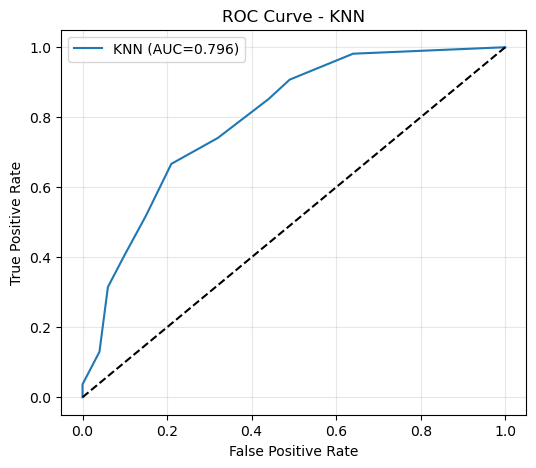

In [8]:
# 8. ROC 곡선 시각화
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'KNN (AUC={roc_auc:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN')
plt.legend()
plt.grid(alpha=0.3)
plt.show()